# Homework
1. Kaggle에서 regression 관련 dataset을 찾아 .csv 파일 등등을 다운받고
2. 해당 dataset을 load하여 regression을 통해 최대한 높은 regression 정확도 달성해보기

Training Start...


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Epoch [200/3000], Loss: 17787474.0000, LR: 0.010000
Epoch [400/3000], Loss: 13077337.0000, LR: 0.010000
Epoch [600/3000], Loss: 10311457.0000, LR: 0.005000
Epoch [800/3000], Loss: 9423272.0000, LR: 0.002500
Epoch [1000/3000], Loss: 8205246.0000, LR: 0.001250
Epoch [1200/3000], Loss: 8322585.0000, LR: 0.000156
Epoch [1400/3000], Loss: 7504814.5000, LR: 0.000010
Epoch [1600/3000], Loss: 7770629.5000, LR: 0.000001
Epoch [1800/3000], Loss: 8337398.5000, LR: 0.000000
Epoch [2000/3000], Loss: 8008935.5000, LR: 0.000000
Epoch [2200/3000], Loss: 7687663.0000, LR: 0.000000
Epoch [2400/3000], Loss: 8362483.5000, LR: 0.000000
Epoch [2600/3000], Loss: 8265641.0000, LR: 0.000000
Epoch [2800/3000], Loss: 8510483.0000, LR: 0.000000
Epoch [3000/3000], Loss: 7831725.0000, LR: 0.000000
------------------------------------------------
Final Test MSE Loss: 26355594.0000


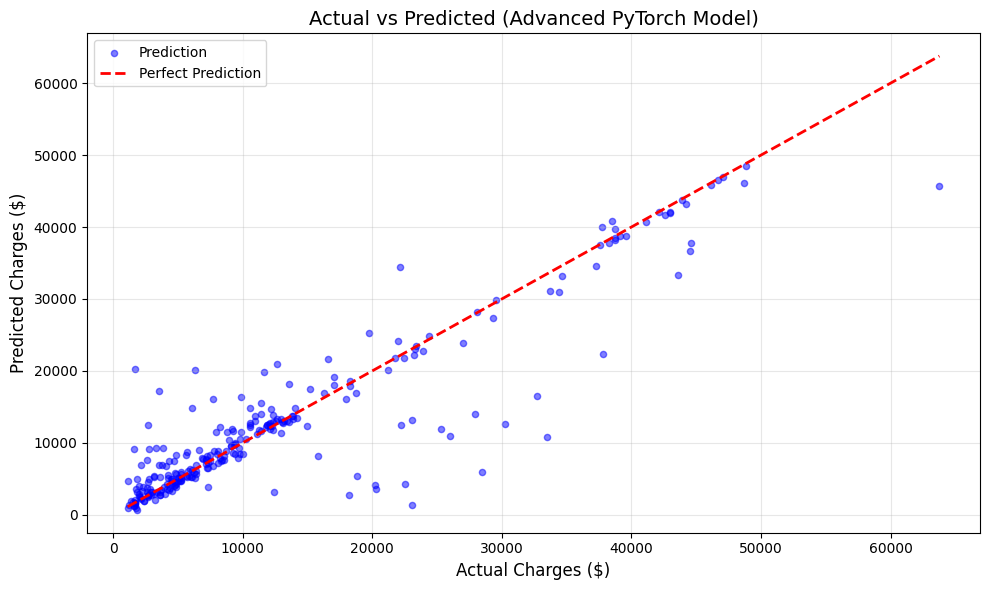


Sample Predictions (first 10 samples):
------------------------------------------------------------
         Actual |       Predicted |      Difference
------------------------------------------------------------
$      9,095.07 | $      9,536.68 | $       -441.61
$      5,272.18 | $      4,725.83 | $        546.35
$     29,330.98 | $     27,410.08 | $      1,920.91
$      9,301.89 | $      9,673.26 | $       -371.37
$     33,750.29 | $     31,073.68 | $      2,676.61
$      4,536.26 | $      4,684.81 | $       -148.55
$      2,117.34 | $      2,183.95 | $        -66.61
$     14,210.54 | $     13,421.20 | $        789.34
$      3,732.62 | $      3,515.19 | $        217.44
$     10,264.44 | $     10,592.09 | $       -327.65


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


df = pd.read_csv('insurance.csv')

X = df.drop('charges', axis=1)
y = df['charges'].values.reshape(-1, 1)

numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


class AdvancedRegressionNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedRegressionNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.output(x)

input_dim = X_train.shape[1]
model = AdvancedRegressionNet(input_dim)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

epochs = 3000
best_loss = float('inf')

print("Training Start...")
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    scheduler.step(loss)

    if (epoch+1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

model.eval()
with torch.no_grad():
    prediction = model(X_test_tensor)
    test_loss = criterion(prediction, y_test_tensor)
    print('------------------------------------------------')
    print(f'Final Test MSE Loss: {test_loss.item():.4f}')

    y_true = y_test_tensor.numpy()
    y_pred = prediction.numpy()

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20, color='blue', label='Prediction')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Charges ($)', fontsize=12)
plt.ylabel('Predicted Charges ($)', fontsize=12)
plt.title('Actual vs Predicted (Advanced PyTorch Model)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSample Predictions (first 10 samples):")
print("-" * 60)
print(f"{'Actual':>15} | {'Predicted':>15} | {'Difference':>15}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0]
    predicted = y_pred[i][0]
    diff = actual - predicted
    print(f"${actual:>14,.2f} | ${predicted:>14,.2f} | ${diff:>14,.2f}")